# Applied Machine Learning PA5: Image Classification

In [1]:
#Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np


# Introduction: Loading images from a directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')


#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Set the directory where the images are stored
imgdir = '/content/drive/MyDrive/a5_images/' # or wherever you put them...
the_file_name = '/content/drive/MyDrive/a5_images/train/car/0055.jpg' #For the part 2

Mounted at /content/drive


It was easy and fast uploading the dataset to google drive. This code block requires permission to access google drive. If you want to get access to dataset by uploading dataset into colab for example, dont forget to change
 'imgdir' path and 'the_file_name' path above . 

In [3]:
# Create an ImageDataGenerator object and rescale pixel values from 0-255 to 0-1
data_gen = ImageDataGenerator(rescale=1.0/255)

# Set the size of the images and the batch size for the generator
img_size = 64
batch_size = 32

def data_generator(directory, image_data_generator, shuffle):
    # Create a data generator that will read images from the specified directory,
    # resize them to the target size, and generate batches of images with their labels
    data_generator = image_data_generator.flow_from_directory(
        imgdir + directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=shuffle)

    # Get the first batch of images and their labels from the data generator
    Xbatch, Ybatch = data_generator.next()
    return Xbatch, Ybatch, data_generator

# Use the data_generator function to create a train generator and get the first batch of images and labels
Xbatch, Ybatch, train_generator = data_generator('/train', data_gen, True)


Found 1600 images belonging to 2 classes.


This code block used several times, for this reason, a function was written to dynamically call this code block. It returns Xbatch, Ybatch and data_generator which is all data.

In [4]:
Xbatch.shape


(32, 64, 64, 3)

The dimensions are (32, 64, 64, 3)

*   32, because there are 32 images in the batch
*   64, for the height of each image
*   64, for the width of each image
*   3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

In [5]:
Ybatch[4]


1.0

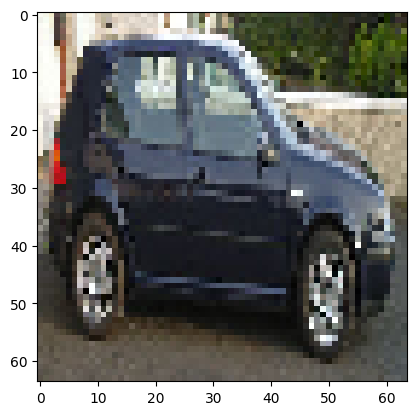

In [6]:
plt.imshow(Xbatch[4]);


# Part 1: Training a convolutional neural network

In [7]:
#Image data generation for the validation part
Xbatch_val, Ybatch_val, validation_generator = data_generator('/validation', data_gen,True)

Found 576 images belonging to 2 classes.


Network here includes 6 building blocks; 2 convolutional, 2 max pooling, and 2 dense layers. The last dense layer has one unit since this is a binary classification task. The number of filters used in layers  are 32 - 64 - 64 - 1 in order. Convolutional 2 Dimensional layers are employed since this is a image processing task. Dropout technique was implemented in order to avoid overfitting but still overfitting are observed. 0.5 dropout rate is selected because it is the most optimized rate. The advantages of the max pooling layers are avoiding overfitting and reduce training time. 

Except for the output layer, relu activation function is selected as a activation function because hidden layers require using relu. This is a binary classification, thus sigmoid activation function is selected. Adam optimizer is selected also because of that.

To determine the number of layers, the codes in the lecture slides were taken. As suggested in the internet resources, the best network structure is found through trial - loss/accuracy experimentation.

In [8]:
#Images has different dimensions like 189x138 or 59x53.
#Some of them in RGB scale but some of them in Grey
def make_convnet(img_size):
    # Initialize a sequential model
    model = Sequential()
    
    # Add a convolutional layer with 32 filters and a kernel size of 5x5
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),activation='relu', input_shape=(img_size,img_size,3)))
    
    # Add a max pooling layer with a pool size of 2x2 and strides of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Add a dropout layer with a rate of 0.5
    model.add(Dropout(0.5))
    
    # Add another convolutional layer with 64 filters and a kernel size of 5x5
    model.add(Conv2D(64, (5, 5), activation='relu'))
    
    # Add another max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Add another dropout layer with a rate of 0.5
    model.add(Dropout(0.5))
    
    # Flatten the output from the previous layer
    model.add(Flatten())
    
    # Add a dense layer with 64 units and ReLU activation
    model.add(Dense(64, activation='relu'))
    
    # Add another dropout layer with a rate of 0.5
    #model.add(Dropout(0.5))
    
    # Add an output layer with one unit and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model using the Adam optimizer and binary cross-entropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create an instance of the CNN classifier with an image size of 64x64
cnn_clf = make_convnet(64)

# We got 1600 rows for the training, 
history = cnn_clf.fit(train_generator, epochs=50, batch_size=32, validation_data = validation_generator)

# We got 576 rows for the validation data

Epoch 1/50
50/50 [==============================] - 279s 6s/step - loss: 0.6885 - accuracy: 0.5813 - val_loss: 0.6534 - val_accuracy: 0.5972
Epoch 2/50
50/50 [==============================] - 27s 542ms/step - loss: 0.6025 - accuracy: 0.6731 - val_loss: 0.5760 - val_accuracy: 0.7309
Epoch 3/50
50/50 [==============================] - 29s 579ms/step - loss: 0.5458 - accuracy: 0.7300 - val_loss: 0.5263 - val_accuracy: 0.7587
Epoch 4/50
50/50 [==============================] - 29s 581ms/step - loss: 0.5249 - accuracy: 0.7406 - val_loss: 0.5373 - val_accuracy: 0.7569
Epoch 5/50
50/50 [==============================] - 27s 550ms/step - loss: 0.4852 - accuracy: 0.7706 - val_loss: 0.5130 - val_accuracy: 0.7656
Epoch 6/50
50/50 [==============================] - 27s 535ms/step - loss: 0.4519 - accuracy: 0.8031 - val_loss: 0.5090 - val_accuracy: 0.7622
Epoch 7/50
50/50 [==============================] - 29s 591ms/step - loss: 0.4336 - accuracy: 0.8031 - val_loss: 0.5036 - val_accuracy: 0.7743
E

Training and validation accuracies are increased, losses are decreased after each epoch iteration but this model is overfitting to training dataset. The accuracy of training is much higher than the accuracy of validation. This situation shows that there is a generalization problem for this model. 

In [9]:
cnn_clf.save_weights('my_model_weights.h5')
#cnn_clf.load_weights('my_model_weights.h5')


Weights are saved in order to not to train the model one more time because training operation is time consuming. 

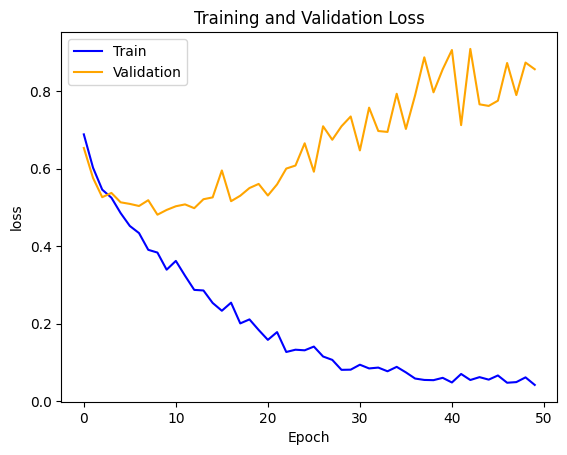

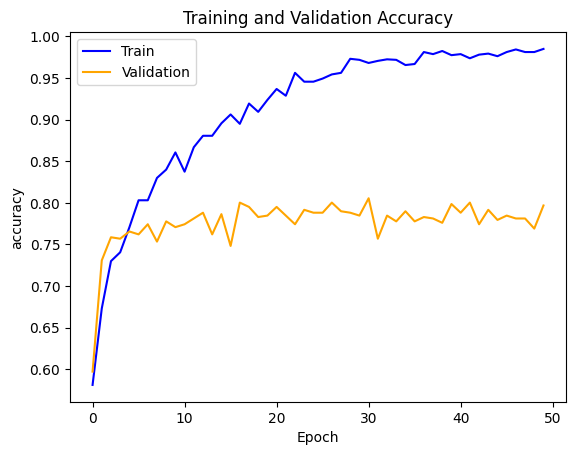

In [10]:
def plot_loss_epoch(history, metric, title):
    """
    Plots the training and validation loss or accuracy over epochs.
    
    :param history_train: History object from training the model
    :param history_validation: History object from validating the model
    :param metric: The metric to plot ('loss' or 'accuracy')
    :param title: The title of the plot (default: 'Training and Validation')
    """
    
    # Plot the training and validation loss or accuracy
    plt.plot(history.history[metric], color='blue', label='Train')
    plt.plot(history.history['val_'+metric], color='orange', label='Validation')
    
    # Set the title, labels and legend
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.show()

# Plot the training and validation loss
plot_loss_epoch(history, 'loss', 'Training and Validation Loss')

# Plot the training and validation accuracy
plot_loss_epoch(history, 'accuracy', 'Training and Validation Accuracy')


As observed during training, model can't generalize to unseen data. The gap between training and validation is huge. 

In [11]:
# Evaluate the model on the validation data
score_validation = cnn_clf.evaluate(validation_generator)
# Print the validation loss and accuracy
print(f'Validation loss: {score_validation[0]} / Test accuracy: {score_validation[1]}')

# Evaluate the model on the training data
score_training = cnn_clf.evaluate(train_generator)
# Print the training loss and accuracy
print(f'Train loss: {score_training[0]} / Test accuracy: {score_training[1]}')



18/18 [==============================] - 4s 240ms/step - loss: 0.8568 - accuracy: 0.7969
Validation loss: 0.8567612171173096 / Test accuracy: 0.796875
50/50 [==============================] - 9s 183ms/step - loss: 0.0075 - accuracy: 0.9994
Train loss: 0.007451996672898531 / Test accuracy: 0.9993749856948853


One of the reasons why overfiting occurs is that, the training dataset is quite small. To avoid overfitting,   dropout and max pooling techniques are applied but they are unsufficient.Data augmentation, regularizing, early stopping might be used. 







---








# ***Part 2: Data augmentation***


In this  part , data augmentation techniques  are applied in the tarined CNN model. The main purpose of applying data augmentation technique  is to increase the existing  training set  by applying various transformations to the images. By this application, the model can learn from diverse set of images, and we can reduce the risk of overfitting in the model so the model will learn new patterns from the images. To implement this, a  new image data generator is created to perform the data augmentation techniques set such as rotation , shearing, zooming etc on the training set . This makes the model to  learn from a wide range of variations from the training set rather than learning from specific patterns. By this the performance of the model is increased for the unseen data and as a result, we have reduced the overfitting in the model.The  loss function is further minimized and the model has shown an improved performance on unseen data. This application of the data augumentation has made the model robust and  to identify the images regardless of the shape , size , position.

In [12]:
newtrainset_datagen = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True,
    fill_mode='nearest',  
    rescale=1.0/255
)

Xbatch_new, Ybatch_new, train_generator  = data_generator('/train', newtrainset_datagen, True)

def make_convnet(img_size):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu', input_shape=(img_size,img_size,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # since it is a binary classification
    return model

Xbatch_new, Ybatch_new = train_generator.next()

model = make_convnet(img_size)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
   
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, batch_size=batch_size)


Found 1600 images belonging to 2 classes.
Epoch 1/50
50/50 [==============================] - 21s 373ms/step - loss: 0.6953 - accuracy: 0.5181 - val_loss: 0.6878 - val_accuracy: 0.6076
Epoch 2/50
50/50 [==============================] - 18s 359ms/step - loss: 0.6848 - accuracy: 0.5813 - val_loss: 0.6558 - val_accuracy: 0.6667
Epoch 3/50
50/50 [==============================] - 21s 413ms/step - loss: 0.6540 - accuracy: 0.6350 - val_loss: 0.6366 - val_accuracy: 0.6476
Epoch 4/50
50/50 [==============================] - 18s 358ms/step - loss: 0.6254 - accuracy: 0.6562 - val_loss: 0.5962 - val_accuracy: 0.7083
Epoch 5/50
50/50 [==============================] - 21s 410ms/step - loss: 0.6280 - accuracy: 0.6538 - val_loss: 0.5845 - val_accuracy: 0.7083
Epoch 6/50
50/50 [==============================] - 18s 360ms/step - loss: 0.5854 - accuracy: 0.6950 - val_loss: 0.5675 - val_accuracy: 0.7101
Epoch 7/50
50/50 [==============================] - 21s 413ms/step - loss: 0.5698 - accuracy: 0.7175

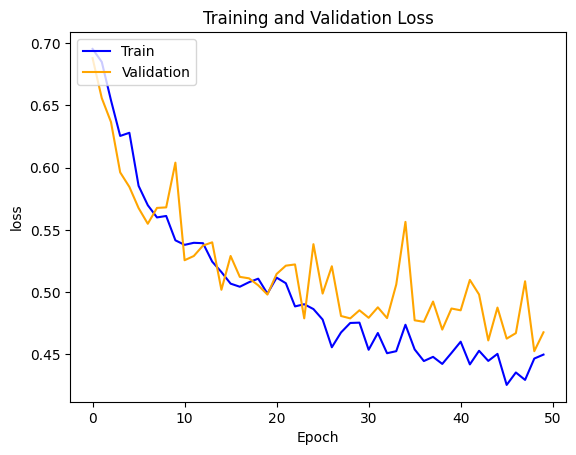

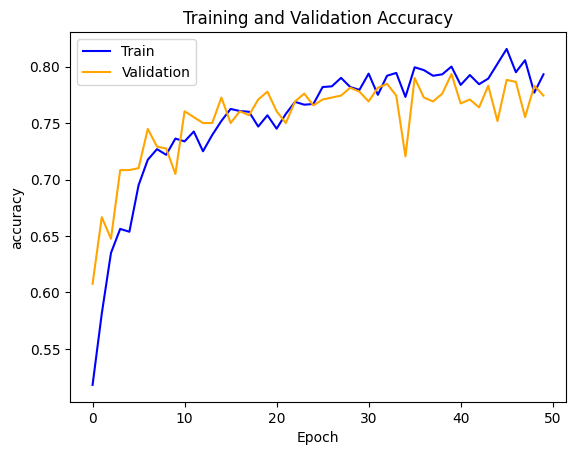

In [13]:
plot_loss_epoch(history, 'loss','Training and Validation Loss')
plot_loss_epoch(history, 'accuracy','Training and Validation Accuracy')
model.save_weights("model_weights.h5")

In [14]:
# Evaluate the model on the validation data
score_validation_data_augment = cnn_clf.evaluate(validation_generator)
# Print the validation loss and accuracy
print(f'Validation loss: {score_validation_data_augment[0]} / Test accuracy: {score_validation_data_augment[1]}') 

# Evaluate the model on the training data
score_training_data_augment = cnn_clf.evaluate(train_generator)
# Print the training loss and accuracy
print(f'Train loss: {score_training_data_augment[0]} / Test accuracy: {score_training_data_augment[1]}')   # is this train accuracy



18/18 [==============================] - 5s 276ms/step - loss: 0.8568 - accuracy: 0.7969
Validation loss: 0.8567612171173096 / Test accuracy: 0.796875
50/50 [==============================] - 13s 255ms/step - loss: 1.0176 - accuracy: 0.7300
Train loss: 1.017555594444275 / Test accuracy: 0.7300000190734863


In [15]:
# Interlude : Applying a pre-trained Convolutional Neural Network
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 2s 0us/step


***Interlude Applying a pretrained convolutional pretrained Neural Network***

In this part, we have demonstrated the application of pre trained model VGG 16 on the image of the  training set . In this we have used the image from the training set and the image  converted into an array using img_to_array and reshaped into the dimensions to match with the shape of VGG 16. By using the VGG predict function the VGG16 model has provided the predicted probabilities of the classes . This prediction has provided insights about the image classification model architecture , the design of various layers and its hierarchical structure and the large data sets for training the model is crucial to extract the meaningful features from the images for the accurate predictions . This shows that the model architecture ,the choice on the number and size of the layers , the data set can impact the CNN model performance if not well designed. 

In [16]:
# loading image file 

file =load_img(the_file_name, target_size=(224,224))
# image file conversion
convert_file  = img_to_array(file)
new_file = preprocess_input(convert_file)
new_file = new_file.reshape(1, 224, 224, 3)

# making the predictions using VGG-16 model
predict_imagevalues = vggmodel.predict(new_file)
decoded_values = decode_predictions(predict_imagevalues, top=5)
for value in decoded_values:
    name = value[1]
    probability = value[2]
    print(value[1], value[2])

35363/35363 [==============================] - 0s 0us/step
('n04037443', 'racer', 0.25828895) ('n02974003', 'car_wheel', 0.06933148)


# PART 3: Using VGG-16 as a feature extractor

In [17]:

feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
                        
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)



58889256/58889256 [==============================] - 0s 0us/step


The instructions are applied here similarly in the assignment. The main task here is to use pre-trained layers which are trained on millions of images. So that, we will increase the performance and avoid overfitting. We only put the highest layer into training by setting include_top parameter to False. Imagenet database is source of the millions of the image data. As suggested above, the dataset that we have include different type of dimensions and color scales, so by creating ImageDataGenerator object, we preprocessed them. 

In [18]:
#create pretrained vgg model features...

def create_vgg16_features(vgg_data_gen, path):
    """
    Extracts features from images using a pre-trained VGG16 model.
    
    :param vgg_data_gen: An ImageDataGenerator object for preprocessing the images
    :param path: The path to the directory containing the images
    """
    
    # Set the directory path
    directory = '/' + path
    
    # Generate data from the images in the directory
    Xbatch_vgg, Ybatch_vgg, generator = data_generator(directory, vgg_data_gen, shuffle=False)
    
    # Extract features from the images using the pre-trained VGG16 model. Returns 4 dimensional numpy array
    cnn_features = feature_extractor.predict(generator)
    
    # Save the extracted features to a file
    filename = path + '.txt'
    with open(filename, 'wb') as f:
        np.save(f, cnn_features)
      
    return generator
# Call the function two times
train_gen = create_vgg16_features(vgg_data_gen, 'train')
validation_gen = create_vgg16_features(vgg_data_gen, 'validation')

Found 1600 images belonging to 2 classes.
50/50 [==============================] - 91s 2s/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 31s 2s/step


Top layers design consist of 2 hidden and 1 output layer. 1 hidden layer is aslo sufficient. Similarly, sigmoid activation function is used in the output layer and adam optimer selected as an optimizer method. 

In [19]:

def get_labels(n):
    """
    Generates an array of labels for binary classification.
    
    :param n: The number of labels to generate
    :return: An array of labels with n//2 zeros followed by n//2 ones
    """
    
    return np.array([0] * (n // 2) + [1] * (n // 2))

def train_on_cnnfeatures():
    """
    Trains a classifier on extracted features from a pre-trained VGG16 model.
    
    :return: A trained classifier and the training and validation data
    """
    
    # Load the training and validation data from files
    with open('train.txt', 'rb') as f:
        the_data_train = np.load(f)
    
    with open('validation.txt', 'rb') as fi:
        the_data_validation = np.load(fi)
    
    # Initialize a sequential model
    model = Sequential()
    
    # Add a flatten layer to flatten the input data
    model.add(Flatten())
    
    # Add a dense layer with 96 units and ReLU activation
    model.add(Dense(96, activation='relu'))
    
    # Add a dropout layer with a rate of 0.4
    model.add(Dropout(0.4))
    
    # Add another dense layer with 16 units and ReLU activation
    model.add(Dense(16, activation='relu'))
    
    # Add another dropout layer with a rate of 0.4
    model.add(Dropout(0.4))
    
    # Add an output layer with one unit and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model using the Adam optimizer and binary cross-entropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model, the_data_train, the_data_validation

# Train a classifier on extracted features from a pre-trained VGG16 model
model, the_data_train, the_data_validation = train_on_cnnfeatures()


Train the model with 50 epochs and using batch size of 32. We faced a problem here that we only fit one bacth and we got different weirds results. Training dataset has 1600 images, validation has 576. This is a supervised learning. 800 of the training images were cars and the other half was noise. Even having noisy data help us to classify better in neural network design. 

In [20]:
# Train the classifier on the training data for up to 50 epochs using a batch size of 32
history_train_vgg = model.fit(the_data_train, get_labels(1600), epochs=50, batch_size=32,validation_data = (the_data_validation,get_labels(576)))

Epoch 1/50
50/50 [==============================] - 2s 16ms/step - loss: 2.1512 - accuracy: 0.6750 - val_loss: 0.4997 - val_accuracy: 0.7760
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6443 - accuracy: 0.7500 - val_loss: 0.4217 - val_accuracy: 0.7326
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.5316 - accuracy: 0.7556 - val_loss: 0.3680 - val_accuracy: 0.8438
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.5011 - accuracy: 0.8075 - val_loss: 0.3183 - val_accuracy: 0.8490
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.4408 - accuracy: 0.8131 - val_loss: 0.3090 - val_accuracy: 0.8472
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.3588 - accuracy: 0.8406 - val_loss: 0.3031 - val_accuracy: 0.8594
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.3756 - accuracy: 0.8350 - val_loss: 0.2776 - val_accuracy: 0.8802
Epoch 8/50
50

The accuracies are very close to each other and as expected, training accurasy is slightly higher than validation accuracy. The main difference is validation loss is greater than training loss. 

In [21]:

# Evaluate the classifier on the validation data
evaluationg_vgg_validation = model.evaluate(the_data_validation,get_labels(576))

# Print the validation loss and accuracy
print(f'VGG Validation loss: {evaluationg_vgg_validation[0]:.4f}')
print(f'VGG Validation accuracy: {evaluationg_vgg_validation[1]:.4f}')

# Evaluate the classifier on the training data
evaluationg_vgg_train = model.evaluate(the_data_train,get_labels(1600))

# Print the training loss and accuracy
print(f'VGG Train loss: {evaluationg_vgg_train[0]:.4f}')
print(f'VGG Train accuracy: {evaluationg_vgg_train[1]:.4f}')
    

18/18 [==============================] - 0s 3ms/step - loss: 0.7930 - accuracy: 0.9132
VGG Validation loss: 0.7930
VGG Validation accuracy: 0.9132
50/50 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
VGG Train loss: 0.0015
VGG Train accuracy: 1.0000


The reason why train loss is 0.0000 is that only 4 fraction digits are printed. 

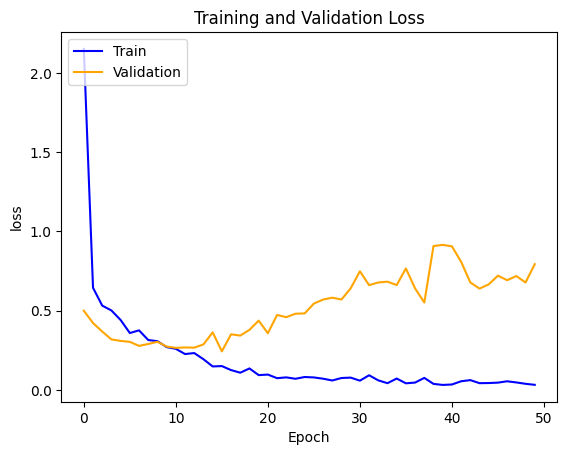

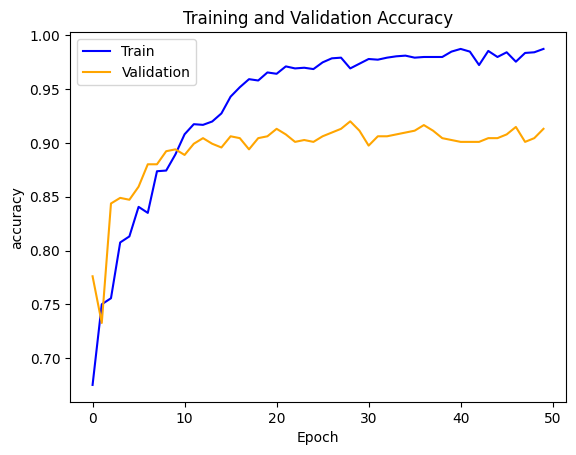

In [22]:

# Plot the training and validation loss
plot_loss_epoch(history_train_vgg, 'loss', 'Training and Validation Loss')

# Plot the training and validation accuracy
plot_loss_epoch(history_train_vgg, 'accuracy','Training and Validation Accuracy')    

The accuracy & loss gap might be seen as huge but the scale is quite narrow. As expected, much better model and results are obtained compared to first model in terms of accuracy, loss, generalization, overfitting and so on. 

# Part 4: Visualizing the learned features

we have visualized the learned features of the convolution first layer from VGG 16 model. The function kernel_ images take the inputs weights tensor from the first convolution layer of VGG 16, the number of filters in the layer and the Boolean value true or false in the positive value indicates to visualize the positive pattern or the negative pattern of the filter.
When the value is  positive  the function to shows the pattern that represents the presence of specific feature or pattern   detected by the filter in the areas of the input .The negative patterns represent the weak or the absence of pattern in the filter .This has given insights about the filters feature extraction. 


In [23]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [24]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

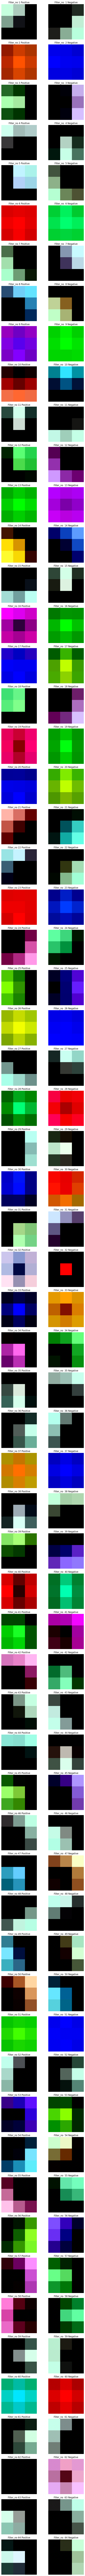

In [25]:
from matplotlib import pyplot as plt

number_filters = first_layer_weights.shape[3]
fig, axes = plt.subplots(number_filters, 2, figsize=(8, 3*number_filters))

for i in range(number_filters):
    
    positive_pattern = kernel_image(first_layer_weights, i, positive=True)
    negative_pattern = kernel_image(first_layer_weights, i, positive=False)

    # displays the positive pattern of the filter
    axes[i, 0].imshow(positive_pattern)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Filter_no {i+1} Positive")
    # displays the positive pattern of the filter
    axes[i, 1].imshow(negative_pattern)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Filter_no  {i+1} Negative")

plt.tight_layout()
plt.show()
